In [175]:
import numpy as np
import random
import pandas as pd
import string
import re
import os
from tempfile import mkdtemp
from shutil import rmtree
from zhon.hanzi import punctuation
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
import seaborn as sns
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('universal_tagset')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/winston/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/winston/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/winston/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!
[nltk_data] Downloading package wordnet to /home/winston/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/winston/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Question 1
- How many rows and columns (features) are present in the dataset?
- Plot 3 histograms on : (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis; (b) The column leaf label – class on the x-axis; (c) The column root label – class on the x-axis.
- Provide qualitative interpretations of the histograms.

In [2]:
df = pd.read_csv('Project1-Classification.csv')

In [3]:
print('rows', df.index)
print('columns', df.columns)

rows RangeIndex(start=0, stop=3150, step=1)
columns Index(['full_text', 'summary', 'keywords', 'publish_date', 'authors', 'url',
       'leaf_label', 'root_label'],
      dtype='object')


In [4]:
an_lengthes = []

for point in df['full_text']:
    # print(point)
    # s = re.sub(r'[.,"\'-?:!;]', '', s)
    cur_len = re.findall('[a-zA-Z0-9_]', point)
    # print(cur_len)
    
    # print(cur_len)
    an_lengthes.append( len(cur_len) )
    # break

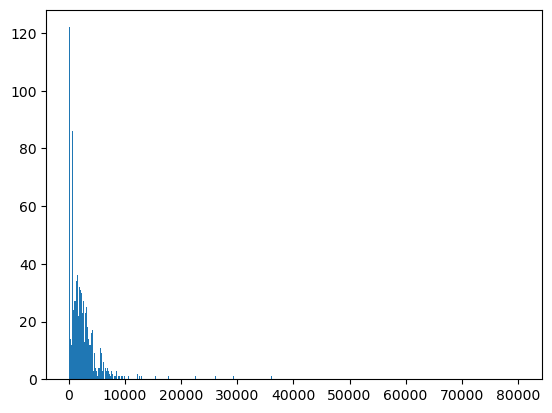

In [5]:
df['alphanumeric_character_num'] = an_lengthes
num_bins = len(set(an_lengthes))
plt.hist(df['alphanumeric_character_num'], bins=num_bins)
plt.savefig('hist_1a.png')
plt.show()


sports     1750
climate    1400
Name: root_label, dtype: int64


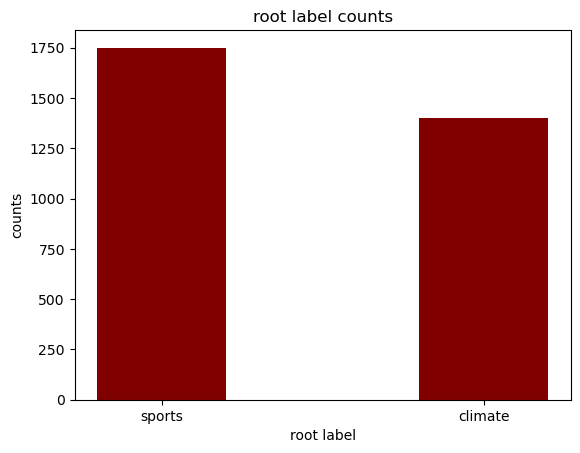

In [6]:
roots = df.root_label.value_counts()
print(roots)
plt.bar(roots.index, roots.values, color ='maroon',
        width = 0.4)
plt.xlabel("root label")
plt.ylabel("counts")
plt.title('root label counts')
plt.savefig('hist_1b.png')

hockey                 350
cricket                350
football               350
soccer                 350
chess                  350
%22forest%20fire%22    350
flood                  350
earthquake             350
drought                350
Name: leaf_label, dtype: int64


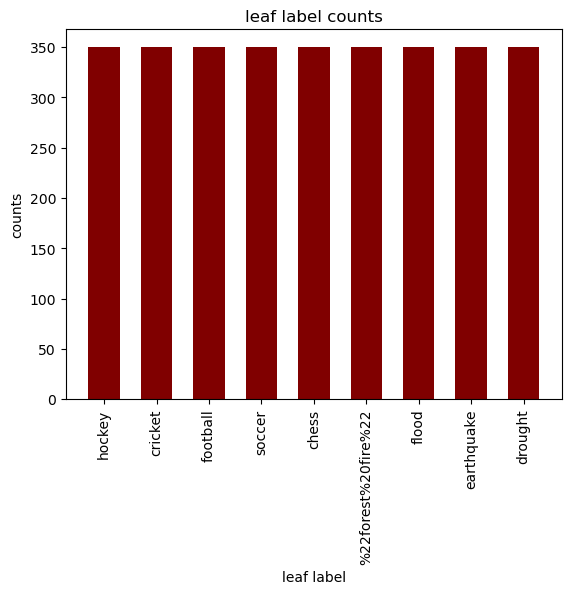

In [7]:
leaf = df.leaf_label.value_counts()
print(leaf)
plt.bar(leaf.index, leaf.values, color ='maroon',
        width = 0.6, )
plt.xlabel("leaf label")
plt.ylabel("counts")
plt.title('leaf label counts')
plt.xticks(rotation=90)
plt.savefig('hist_1c.png')

## Question 2
set the random seed
split the training and test set

In [8]:
np.random.seed(42)
random.seed(42)

In [9]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

In [10]:
print('train length', len(train))
print('test length', len(test))

train length 2520
test length 630


## Question 3
Feature Extraction

In [148]:
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter


def remove_numbers(text):
    text_nonum = re.sub(r'\b[0-9]+\b\s*', '', text)
    clean_text = []
    
    for word in nltk.word_tokenize(text):
        flag = True
        for ch in word:
            if ch.isdigit():
                flag = False
                break
        if not flag:
            continue    
        clean_text.append(word)
    return (" ").join(clean_text)


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # default shoule be noun
        return wordnet.NOUN


def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    pre_sents = nltk.sent_tokenize(text)
    
    words = []
    for sent in pre_sents:
        words_tagged = nltk.pos_tag(nltk.word_tokenize(sent))
        for word in words_tagged:
            words.append(word)
    # print(words)
    words_lemmatized = []
    for w in words:
        words_lemmatized.append(lemmatizer.lemmatize(w[0], pos = get_wordnet_pos(w[-1])).lower())
    return words_lemmatized


def remove_punctuation(words_lemmatized):
    words_wo_punc = []
    for word in words_lemmatized:
        flag = True
        for ch in word:
            if ch in string.punctuation or ch in punctuation:
                flag = False
                break
        if not flag:
            continue
        words_wo_punc.append(word)
    return words_wo_punc

def preprocess(text):
    # remove https info
    text = clean(text)
    # remove numbers
    text = remove_numbers(text)
    # lemmatize
    words_lemmatized = lemmatize_text(text)
    # print(words_lemmatized)
    # remove punctuation
    words_wo_punc = remove_punctuation(words_lemmatized)
    
    return ' '.join(words_wo_punc)

                

In [11]:
train ['cleaned_text'] = train.full_text.apply(lambda x: preprocess(x))
test['cleaned_text'] = test.full_text.apply(lambda x: preprocess(x))

NameError: name 'train' is not defined

In [10]:
def make_preprocess_pipeline(min_df = 3):
    return Pipeline([('count', CountVectorizer(stop_words = 'english', min_df = min_df)), ("tf_idf", TfidfTransformer()) ] )

pipeline = make_preprocess_pipeline(min_df = 3)

train_x = pipeline.fit_transform(train['cleaned_text'])
test_x = pipeline.transform(test['cleaned_text'])

train_x = train_x.toarray()
test_x = test_x.toarray()


NameError: name 'train' is not defined

In [14]:
print(train_x.shape)
print(test_x.shape)

(2520, 14077)
(630, 14077)


## Question 4
- Plot the explained variance ratio across multiple different k = [1,10,50,100,200,500,1000,2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?
- With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the
$|X - WH|^2_F$ in NMF or the $|X - U_KE_KV_K^T|^2_F$ in LSI and why?

1
10
50
100
200
500
1000
2000


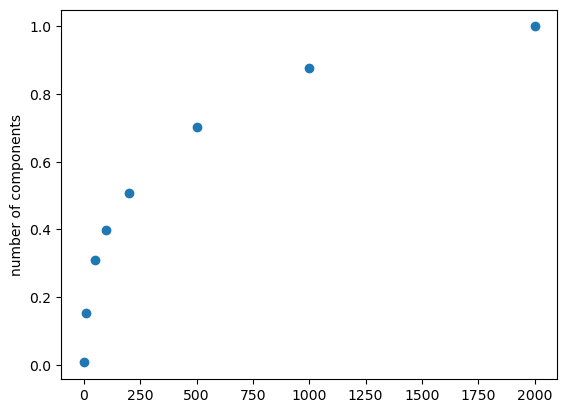

In [17]:
ks = [1,10,50,100,200,500,1000,2000]
ratio_sum = []
for k in ks: 
    lsa = TruncatedSVD(n_components=k, random_state=42)
    lsa.fit(train_x)
    ratio_sum.append( lsa.explained_variance_ratio_.sum())
    print(k)
plt.plot(ks, ratio_sum, "o")
plt.ylabel('explained variance ratio')
plt.ylabel('number of components')
plt.savefig("figs/k_vs_explained_variance_ratio.png")
plt.show()

In [15]:
nmf = NMF(n_components=50, init='random', random_state=42)

nmf.fit(train_x)


model = NMF(n_components=50, init='random', random_state=42)
W = model.fit_transform(train_x)
H = model.components_

nmf_err = np.sum(np.square(np.array(train_x - (W @ H))))

print("nmf error", nmf_err)


/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


nmf error 1709.5207304045632


In [16]:
u, s, vh = np.linalg.svd(train_x)
sd = np.diag(s)
vht = np.transpose(vh)

lsa_err = np.sum(np.square(train_x  - np.matmul( np.matmul(u[:, :50], sd[0:50, 0:50]), vht[:50, :] ) ))

print("lsa error", lsa_err)

lsa error 3352.587241636167


## Question 5 


In [20]:
def get_root_label(label):
    if label == 'sports':
        return 1
    if label == "climate":
        return 0

train_y = train.root_label.apply(lambda x: get_root_label(x))
test_y = test.root_label.apply(lambda x:get_root_label(x))

In [170]:
def plot_confusion_matrix(y, y_pred, labels, name = '', fig_path = None):
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=labels)
    ax.set(title = "Confusion Matrix of %s" % (name))
    disp.plot(ax=ax)
    if fig_path is not None:
        plt.savefig(fig_path)
    plt.show()
    plt.close()


def show_metrics(y,y_pred,name="",average='binary'):
    print("Accuracy score for %s: %.4f" %(name,accuracy_score(y,y_pred)))
    print("Recall score for %s: %.4f" % (name,recall_score(y,y_pred,average=average)))
    print("Precision score for %s: %.4f" % (name,precision_score(y,y_pred,average=average)))
    print("F-1 score for %s: %.4f" % (name,f1_score(y,y_pred,average=average)))
    

def plot_roc(y, x, function, name = '', fig_path = None):
    
    y_pred_proba = function(x)
    
    if len(y_pred_proba.shape) >1 and y_pred_proba.shape[-1] > 1:
        y_pred_proba = y_pred_proba[::,1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    auc = roc_auc_score (y, y_pred_proba)
    
    plt.plot(fpr, tpr, label = 'AUC=' + str(auc))
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Postive Rate")
    plt.title("ROC curve of %s" % (name))
    plt.legend(loc = 4)
    if fig_path is not None:
        plt.savefig(fig_path)
    plt.show()
    plt.close()


In [22]:
clf_hard = svm.SVC(kernel='linear', C = 1000, random_state = 42)
clf_soft = svm.SVC(kernel='linear', C = 0.0001, random_state = 42)

labels = ['sports', 'climate']


nmf = NMF(n_components=50, init='random', random_state=0)
nmf.fit(train_x)

dense_train_x = nmf.transform(train_x)
dense_test_x = nmf.transform(test_x)


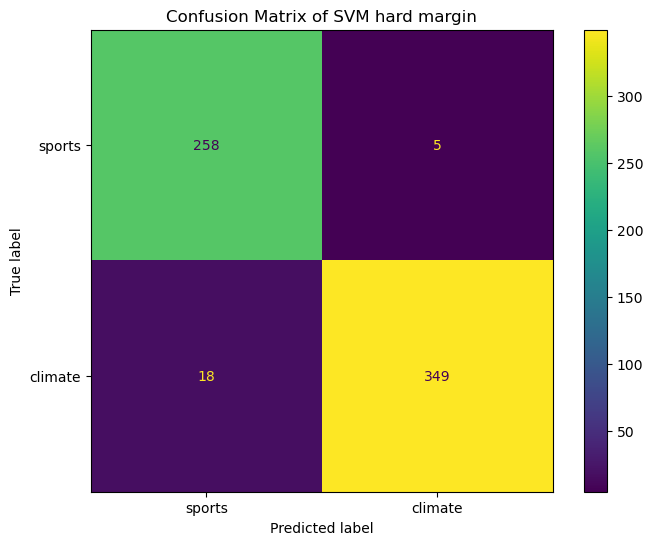

Accuracy score for SVM hard margin: 0.963
Recall score for SVM hard margin: 0.951
Precision score for SVM hard margin: 0.986
F-1 score for SVM hard margin: 0.968


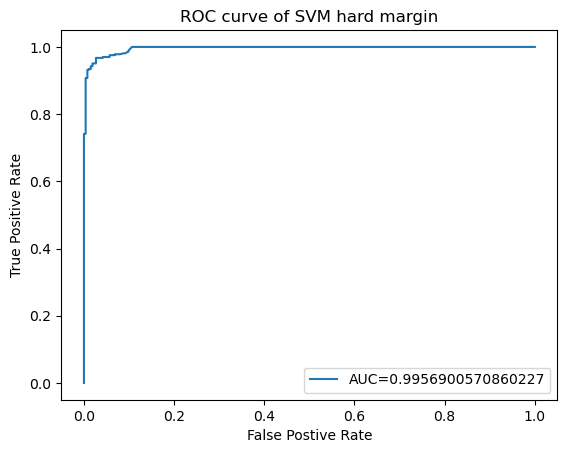

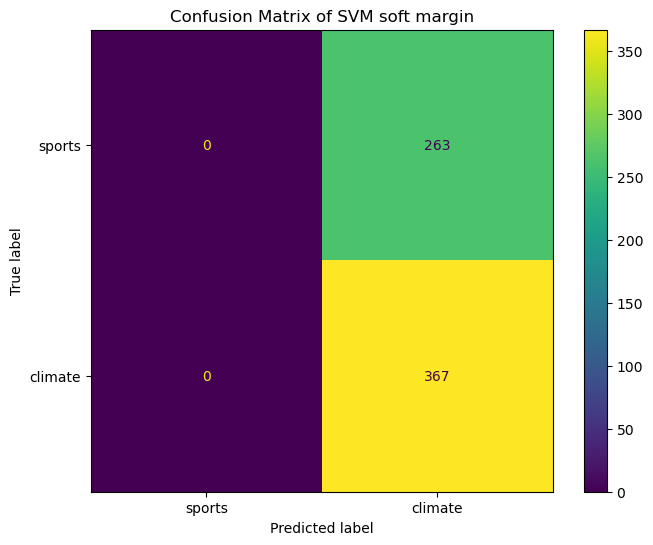

Accuracy score for SVM soft margin: 0.583
Recall score for SVM soft margin: 1.000
Precision score for SVM soft margin: 0.583
F-1 score for SVM soft margin: 0.736


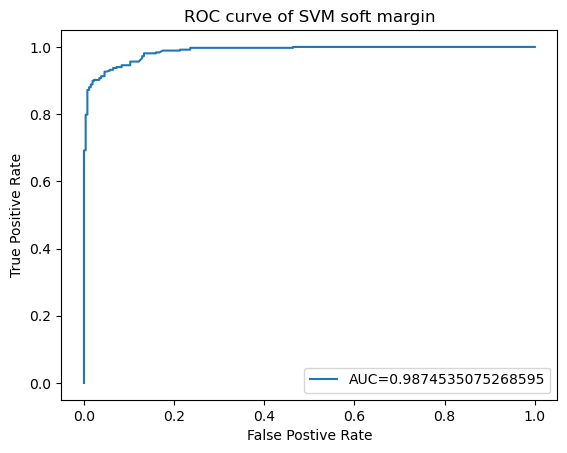

In [52]:
# Fit
clf_hard.fit(dense_train_x, train_y)
clf_soft.fit(dense_train_x, train_y)
# Report Metric

y_pred_hard = clf_hard.predict(dense_test_x)
y_pred_soft = clf_soft.predict(dense_test_x)

plot_confusion_matrix(test_y, y_pred_hard, labels = labels, name = 'SVM hard margin', fig_path = "figs/cm_svm_hard.png")
show_metrics(test_y, y_pred_hard, name = "SVM hard margin")
plot_roc(test_y, dense_test_x, clf_hard.decision_function, name = 'SVM hard margin', fig_path = "figs/roc_svm_hard.png")

plot_confusion_matrix(test_y, y_pred_soft, labels = labels, name = 'SVM soft margin', fig_path = "figs/cm_svm_soft.png")
show_metrics(test_y, y_pred_soft, name = "SVM soft margin")
plot_roc(test_y, dense_test_x, clf_soft.decision_function, name = 'SVM soft margin', fig_path = "figs/roc_svm_soft.png")


0.001: 0.548809524 accuracy with a standard deviation of 0.00
0.010: 0.548809524 accuracy with a standard deviation of 0.00
0.100: 0.548809524 accuracy with a standard deviation of 0.00
1.000: 0.822619048 accuracy with a standard deviation of 0.01
10.000: 0.927380952 accuracy with a standard deviation of 0.01
100.000: 0.945238095 accuracy with a standard deviation of 0.01
1000.000: 0.954365079 accuracy with a standard deviation of 0.01
10000.000: 0.953571429 accuracy with a standard deviation of 0.01
100000.000: 0.953174603 accuracy with a standard deviation of 0.01
1000000.000: 0.952777778 accuracy with a standard deviation of 0.01
Best Gamma:  1000


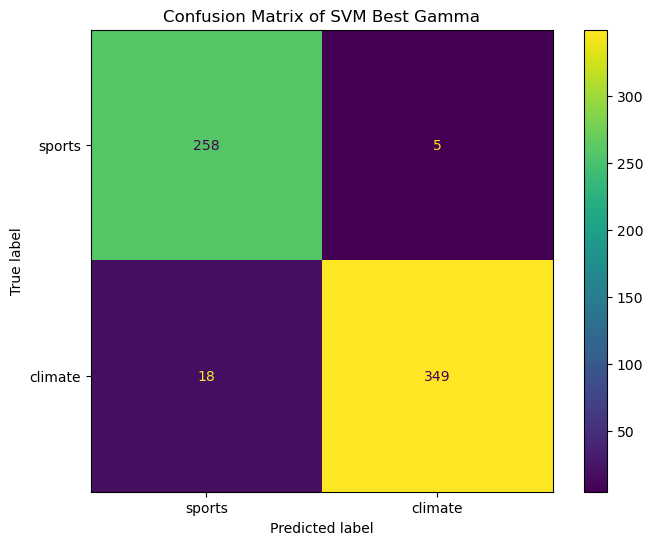

Accuracy score for SVM Best Gamma: 0.963
Recall score for SVM Best Gamma: 0.951
Precision score for SVM Best Gamma: 0.986
F-1 score for SVM Best Gamma: 0.968


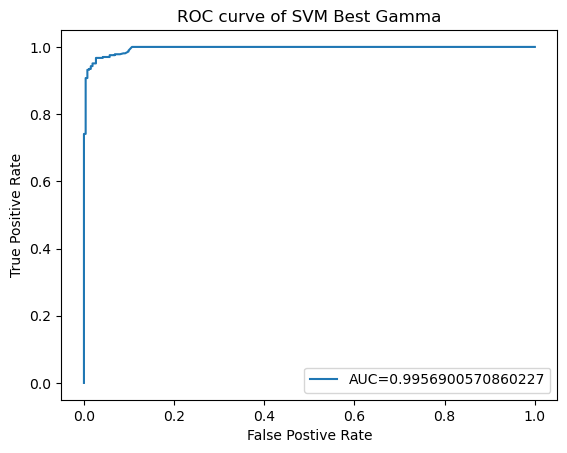

In [24]:
gamma=[ 10 ** i for i in range(-3, 7) ]

best_gamma = 0.001
best_accuracy = 0

# Cross validation/scoring should happen on the training data
for g in gamma:
    clf = svm.SVC(kernel='linear', C=g, random_state=42)
    scores = cross_val_score(clf, dense_train_x, train_y , cv=5)
    print("%0.3f: %0.9f accuracy with a standard deviation of %0.2f" % (g, scores.mean(), scores.std()))
    if scores.mean() > best_accuracy:
        best_accuracy = scores.mean()
        best_gamma = g

print('Best Gamma: ', best_gamma)

best_svc = svm.SVC(kernel='linear',C=best_gamma, random_state=42) 
best_pred = best_svc.fit(dense_train_x, train_y).predict(dense_test_x)

plot_confusion_matrix(test_y, best_pred, labels = labels, name = 'SVM Best Gamma', fig_path = "figs/cm_svm_best.png")
show_metrics(test_y, best_pred, name = "SVM Best Gamma")

plot_roc(test_y, dense_test_x, best_svc.decision_function, name = 'SVM Best Gamma', fig_path = "figs/roc_svm_best.png")

## Question 6

/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


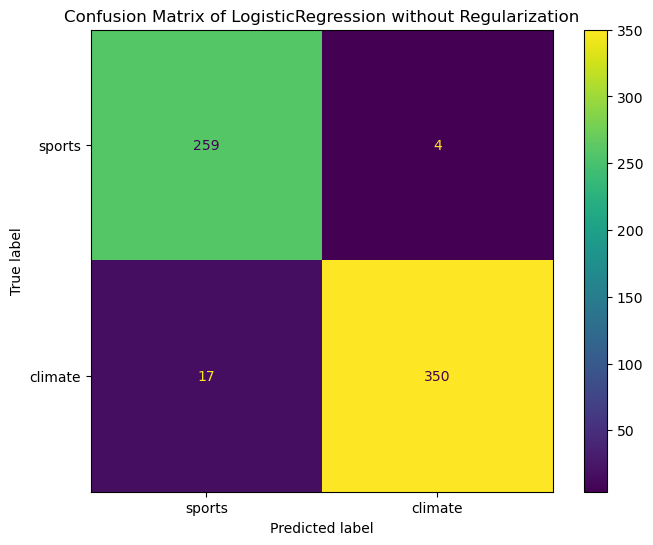

Accuracy score for LogisticRegression without Regularization: 0.967
Recall score for LogisticRegression without Regularization: 0.954
Precision score for LogisticRegression without Regularization: 0.989
F-1 score for LogisticRegression without Regularization: 0.971


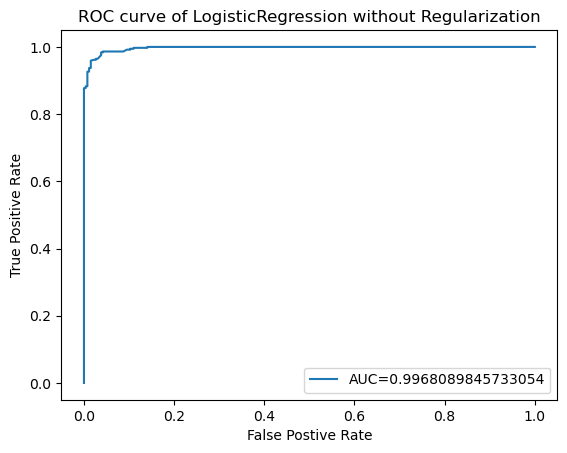

In [23]:
# 6.1
# logistic classifier without regularization (penalty = 'none')
lr_no_reg = LogisticRegression(penalty = 'none',random_state = 42)
y_lr_no_reg_pred = lr_no_reg.fit(dense_train_x,train_y).predict(dense_test_x)

plot_confusion_matrix(test_y, y_lr_no_reg_pred, labels = labels, name = 'LogisticRegression without Regularization', fig_path = "figs/cm_lr_no_reg.png")
show_metrics(test_y, y_lr_no_reg_pred, name = "LogisticRegression without Regularization")
plot_roc(test_y, dense_test_x, lr_no_reg.decision_function, name = 'LogisticRegression without Regularization', fig_path = "figs/roc_lr_no_reg.png")

In [26]:
# 6.2 find optimal regularization coefficient
# 6.2.1 
# 5-fold cross-validation
ks = [10**i for i in range(-5,5)]
best_k_l1 = 0
best_acc = 0
Acc_L1 = []
Coeffi_L1 = []
svd_model = TruncatedSVD(n_components = 50)
svd_model.fit(train_x)
train_x_svd = svd_model.transform(train_x)
test_x_svd = svd_model.transform(test_x)

print(train_x_svd.shape)
print(test_x_svd.shape)
# L1 optimal
for k in ks:
    lr_SVD_L1 = LogisticRegression(penalty = 'l1',random_state = 42, C = k, solver = 'saga', max_iter= 2000 )
    y_L1_pred = lr_SVD_L1.fit(train_x_svd,train_y).predict(test_x_svd)
    scores = cross_val_score(lr_SVD_L1, train_x_svd, train_y, cv=5)
    print("%0.6f: %0.9f accuracy with a standard deviation of %0.2f" % (k, scores.mean(), scores.std()))
    Acc_L1.append(accuracy_score(test_y, y_L1_pred))
    Coeffi_L1.append(lr_SVD_L1.coef_.mean())
    if scores.mean() > best_acc:
        best_k_l1 = k
        best_acc = scores.mean()
print('Best k for L1:', best_k_l1)
k_L1 = best_k_l1


# L2 optimal
best_k_l2 = 0
best_acc = 0
Acc_L2 = []
Coeffi_L2 = []
for k2 in ks:
    lr_SVD_L2 = LogisticRegression(penalty = 'l2',random_state = 42, C = k2, solver = 'saga', max_iter = 2000 )
    y_L2_pred = lr_SVD_L2.fit(train_x_svd,train_y).predict(test_x_svd)
    scores = cross_val_score(lr_SVD_L2, train_x_svd, train_y, cv=5)
    Acc_L2.append(accuracy_score(test_y, y_L2_pred))
    Coeffi_L2.append(lr_SVD_L2.coef_.mean())
    print("%0.6f: %0.9f accuracy with a standard deviation of %0.2f" % (k2, scores.mean(), scores.std()))
    if scores.mean() > best_acc:
        best_k_l2 = k2
        best_acc = scores.mean()
print('Best k for L2:', best_k_l2)
k_L2 = best_k_l2

(2520, 50)
(630, 50)
0.000010: 0.529761905 accuracy with a standard deviation of 0.04
0.000100: 0.529761905 accuracy with a standard deviation of 0.04
0.001000: 0.529761905 accuracy with a standard deviation of 0.04
0.010000: 0.548809524 accuracy with a standard deviation of 0.00
0.100000: 0.921825397 accuracy with a standard deviation of 0.02
1.000000: 0.942460317 accuracy with a standard deviation of 0.01
10.000000: 0.953174603 accuracy with a standard deviation of 0.01
100.000000: 0.956746032 accuracy with a standard deviation of 0.01
1000.000000: 0.957142857 accuracy with a standard deviation of 0.01
10000.000000: 0.956746032 accuracy with a standard deviation of 0.01
Best k for L1: 1000
0.000010: 0.548809524 accuracy with a standard deviation of 0.00
0.000100: 0.548809524 accuracy with a standard deviation of 0.00
0.001000: 0.548809524 accuracy with a standard deviation of 0.00
0.010000: 0.666269841 accuracy with a standard deviation of 0.01
0.100000: 0.921825397 accuracy with a s

In [27]:
# 6.2.2
# Compare scores of 3 Lr
lr_no_reg = LogisticRegression(penalty = 'none',random_state = 42, max_iter= 2000)
y_no_reg_pred = lr_no_reg.fit(train_x_svd,train_y).predict(test_x_svd)

lr_SVD_L1 = LogisticRegression(penalty = 'l1',random_state = 42, C = k_L1, solver = 'saga', max_iter= 2000)
y_L1_pred = lr_SVD_L1.fit(train_x_svd,train_y).predict(test_x_svd)

lr_SVD_L2 = LogisticRegression(penalty = 'l2',random_state = 42, C = k_L2, solver = 'saga', max_iter = 2000)
y_L2_pred = lr_SVD_L2.fit(train_x_svd,train_y).predict(test_x_svd)

show_metrics(test_y, y_no_reg_pred, name = "LR without regularization ")
print('-----')
show_metrics(test_y, y_L1_pred, name = "LR with optimal L1 ")
print('-----')
show_metrics(test_y, y_lr_no_reg_pred, name = "LR without Regularization")

Accuracy score for LR without regularization : 0.965
Recall score for LR without regularization : 0.954
Precision score for LR without regularization : 0.986
F-1 score for LR without regularization : 0.970
-----
Accuracy score for LR with optimal L1 : 0.965
Recall score for LR with optimal L1 : 0.954
Precision score for LR with optimal L1 : 0.986
F-1 score for LR with optimal L1 : 0.970
-----
Accuracy score for LR without Regularization: 0.967
Recall score for LR without Regularization: 0.954
Precision score for LR without Regularization: 0.989
F-1 score for LR without Regularization: 0.971


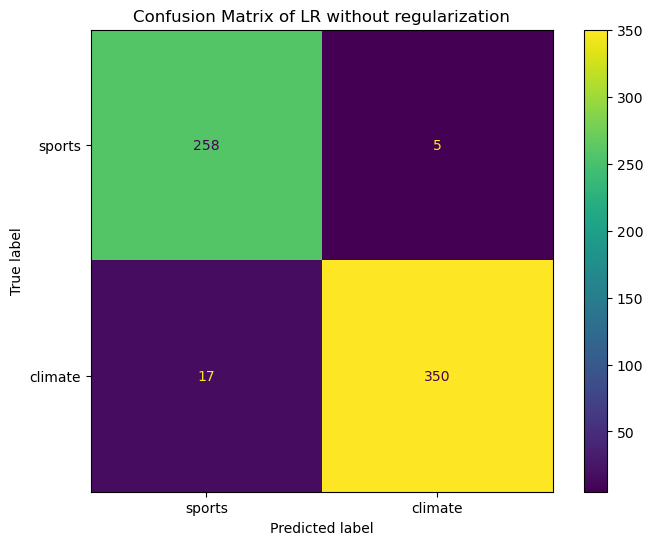

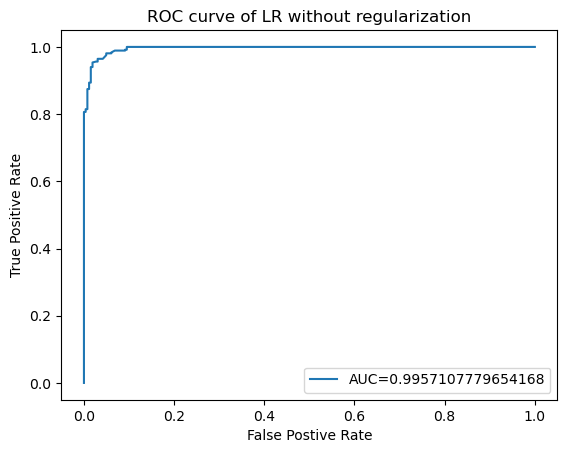

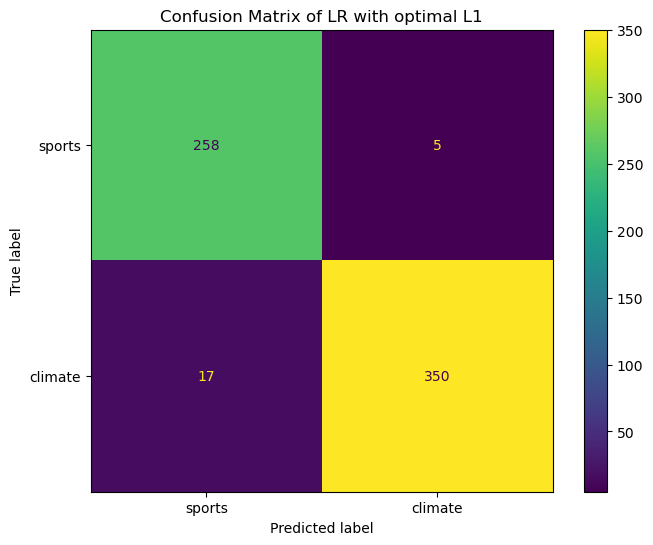

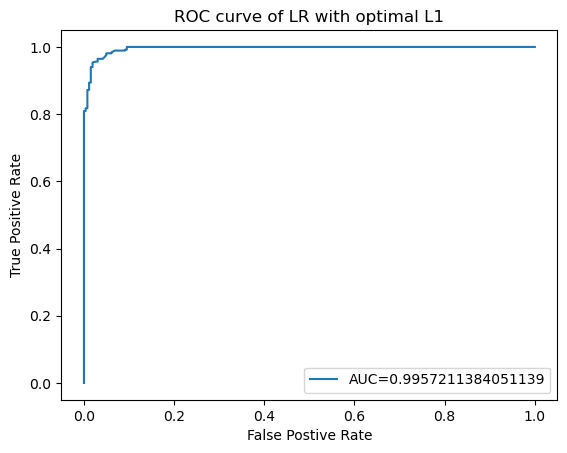

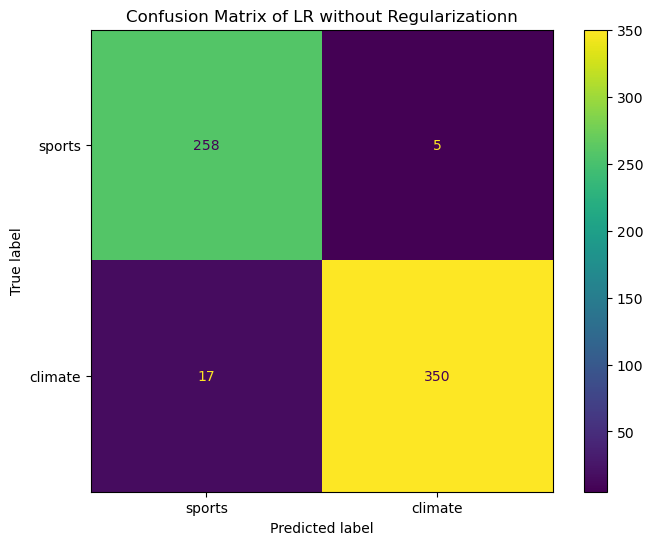

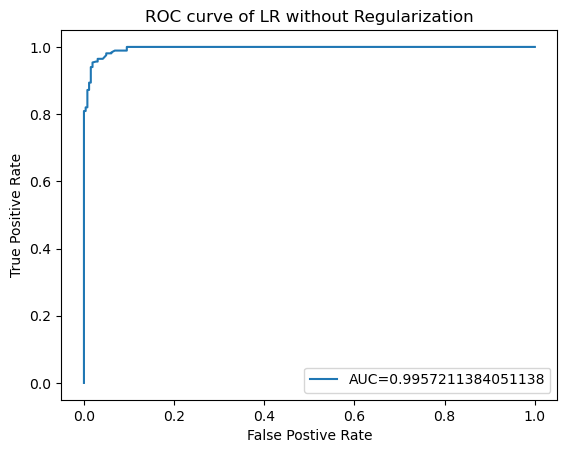

In [29]:
# Plot confusion matrix
labels = ['sports', 'climate']

plot_confusion_matrix(test_y, y_no_reg_pred, labels = labels, name = 'LR without regularization', fig_path = "figs/cm_svm_hard.png")
plot_roc(test_y, test_x_svd, lr_no_reg.decision_function, name = 'LR without regularization', fig_path = "figs/roc_svm_hard.png")

plot_confusion_matrix(test_y, y_L1_pred, labels = labels, name = 'LR with optimal L1', fig_path = "figs/cm_svm_hard.png")
plot_roc(test_y, test_x_svd, lr_SVD_L1.decision_function, name = 'LR with optimal L1', fig_path = "figs/roc_svm_hard.png")

plot_confusion_matrix(test_y, y_L2_pred, labels = labels, name = 'LR without Regularizationn', fig_path = "figs/cm_svm_hard.png")
plot_roc(test_y, test_x_svd, lr_SVD_L2.decision_function, name = 'LR without Regularization', fig_path = "figs/roc_svm_hard.png")

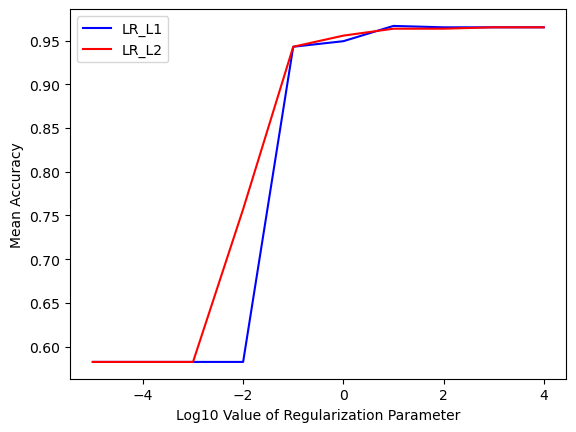

In [40]:
# 6.2.3 How co-effi and test-err are effected by regularization parameter
plt.plot(np.log10(ks),Acc_L1,'b',label = 'LR_L1')
plt.plot(np.log10(ks),Acc_L2,'r',label = 'LR_L2')
plt.xlabel('Log10 Value of Regularization Parameter')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.savefig('figs/Effect_Acc_L1_L2_overall.png')

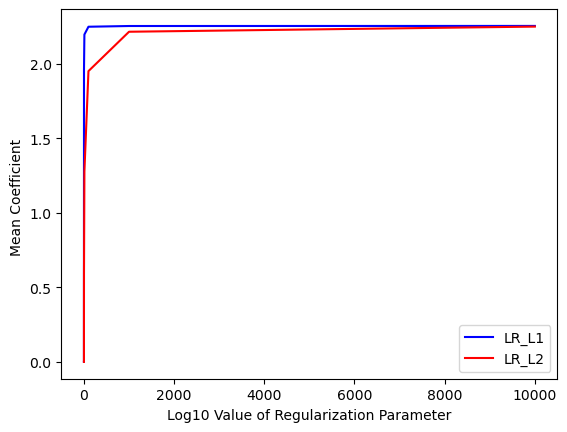

In [42]:
plt.plot(ks,Coeffi_L1,'b',label = 'LR_L1')
plt.plot(ks,Coeffi_L2,'r',label = 'LR_L2')
plt.xlabel('Log10 Value of Regularization Parameter')
plt.ylabel('Mean Coefficient ')
plt.legend()
plt.savefig('figs/Effect_Coeffi_L1_L2.png')

## Question 7

In [44]:
gnb = GaussianNB()
nmf = NMF(n_components=50, init='random', random_state=0)

nmf.fit(train_x)

dense_train_x = nmf.transform(train_x)
dense_test_x = nmf.transform(test_x)

In [46]:

gnb.fit(dense_train_x, train_y)
y_pred_gnb = gnb.predict(dense_test_x)

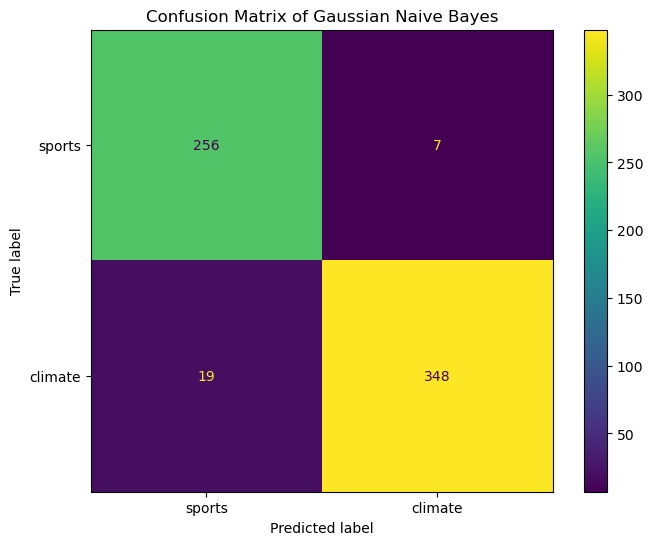

Accuracy score for Gaussian Naive Bayes: 0.959
Recall score for Gaussian Naive Bayes: 0.948
Precision score for Gaussian Naive Bayes: 0.980
F-1 score for Gaussian Naive Bayes: 0.964


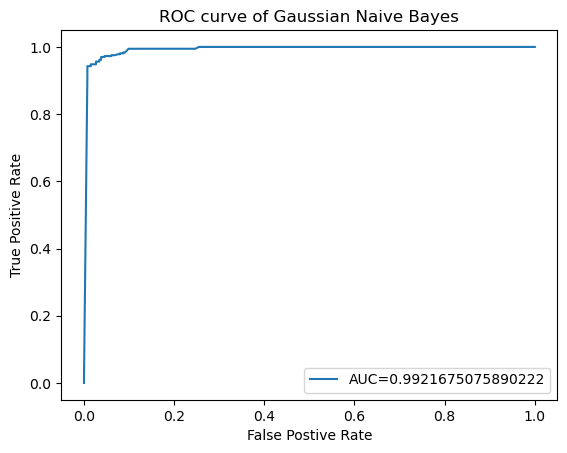

In [58]:
labels = ['sports', 'climate']

plot_confusion_matrix(test_y, y_pred_gnb, labels = labels, name = 'Gaussian Naive Bayes', fig_path = 'figs/cm_gnb.png')
show_metrics(test_y, y_pred_gnb, name = "Gaussian Naive Bayes")
plot_roc(test_y, dense_test_x, gnb.predict_proba, name = 'Gaussian Naive Bayes', fig_path = "figs/roc_gnb.png")


## Question 8

In [96]:

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter


def remove_numbers(text):
    text_nonum = re.sub(r'\b[0-9]+\b\s*', '', text)
    clean_text = []
    
    for word in nltk.word_tokenize(text):
        flag = True
        for ch in word:
            if ch.isdigit():
                flag = False
                break
        if not flag:
            continue    
        clean_text.append(word)
    return (" ").join(clean_text)


def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # default shoule be noun
        return wordnet.NOUN

def clean_without_analysis(text):
    temp_text = clean(text)
    temp_wo_number_text = remove_numbers(temp_text)
    return temp_wo_number_text

def remove_punctuation2(words_lemmatized):
    words_wo_punc = []
    for word in words_lemmatized:
        flag = True
        for ch in word:
            if ch in string.punctuation or ch in punctuation:
                flag = False
                break
        if not flag:
            continue
        words_wo_punc.append(word)
    return words_wo_punc

def lemmatize_text2(text):
    lemmatizer = WordNetLemmatizer()
    pre_sents = nltk.sent_tokenize(text)
    
    words = []
    for sent in pre_sents:
        words_tagged = nltk.pos_tag(nltk.word_tokenize(sent))
        for word in words_tagged:
            words.append(word)
    # print(words)
    words_lemmatized = []
    for w in words:
        words_lemmatized.append(lemmatizer.lemmatize(w[0], pos = get_wordnet_pos(w[-1])).lower())
    
    return ' '.join(remove_punctuation2(words_lemmatized))

def stemming_text2(text):
    stemmer = nltk.PorterStemmer()
    pre_sents = nltk.sent_tokenize(text)
    
    words = []
    for sent in pre_sents:
        words_tagged = nltk.pos_tag(nltk.word_tokenize(sent))
        for word in words_tagged:
            words.append(word)
    # print(words)
    words_stemmed = []
    for w in words:
        words_stemmed.append(stemmer.stem(w[0]).lower() )
    
    return ' '.join(remove_punctuation2(words_lemmatized=words_stemmed))




def get_root_label(label):
    if label == 'sports':
        return 1
    if label == "climate":
        return 0

In [81]:
from sklearn.model_selection import train_test_split
import joblib
df = pd.read_csv("./Project1-Classification.csv")

np.random.seed(42)
random.seed(42)

train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

train_cleaned = train.full_text.apply(lambda x: clean_without_analysis(x))
train_y = train.root_label.apply(get_root_label)
# print(train_cleaned)



In [82]:

for i,  text_process in enumerate([stemming_text2, lemmatize_text2]):
    cachedir = mkdtemp()
    steps =  [ ( "vectorizer", CountVectorizer(stop_words='english') ),
          ("tf_idf", TfidfTransformer()), ('dim_reduction', None), ("clf", None),
    
          ]
    memory=joblib.Memory(cachedir=cachedir, verbose=0)
    steps = Pipeline(steps, memory= memory)
    
    processed_x  = train_cleaned.apply(lambda x: text_process(x))
    # print(processed_x)
    parameters = {
        
        "vectorizer__min_df": (3, 5),
        "dim_reduction": (TruncatedSVD(n_components=5, n_iter = 5, random_state= 42), 
                        TruncatedSVD(n_components=30, n_iter = 5, random_state= 42),
                        TruncatedSVD(n_components=80, n_iter= 5, random_state= 42),
                        NMF(n_components=5, init= 'random' , max_iter = 500 , random_state= 42),
                        NMF(n_components=30, init= 'random' , max_iter = 500 , random_state= 42),
                        NMF(n_components=80, init= 'random' , max_iter = 500 , random_state= 42)),
        
        "clf": (svm.SVC(kernel='linear', C = 1000, random_state= 42, max_iter= 20000),
                LogisticRegression(penalty= 'l1', random_state= 42, C = 1000, solver= 'saga', max_iter= 20000),
                LogisticRegression(penalty= 'l2', random_state= 42, C = 10000, solver= 'saga', max_iter= 20000),
                GaussianNB()),

    }
    
    grid_search = GridSearchCV(steps, cv = 5, param_grid = parameters, n_jobs = -1, scoring= 'accuracy')
    grid_search.fit(processed_x, train_y)
    if i == 0:
        print("stemming")
        print("-------")
    else:
        print("lemmatizing")
        print("-------")
    print("params", grid_search.best_params_)
    # print(grid_search.best_estimator_)
    print("score", grid_search.best_score_)
    print('-------')
    rmtree(cachedir)

/tmp/ipykernel_5138/117752342.py:7: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp/tmp4u01soix'", use "location='/tmp/tmp4u01soix'" instead.
  memory=joblib.Memory(cachedir=cachedir, verbose=0)
/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


stemming
-------
params {'clf': LogisticRegression(C=1000, max_iter=20000, penalty='l1', random_state=42,
                   solver='saga'), 'dim_reduction': NMF(init='random', max_iter=500, n_components=80, random_state=42), 'vectorizer__min_df': 3}
score 0.9591269841269842
-------


/tmp/ipykernel_5138/117752342.py:7: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/tmp/tmp7aoojwya'", use "location='/tmp/tmp7aoojwya'" instead.
  memory=joblib.Memory(cachedir=cachedir, verbose=0)
/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


lemmatize
-------
params {'clf': LogisticRegression(C=1000, max_iter=20000, penalty='l1', random_state=42,
                   solver='saga'), 'dim_reduction': TruncatedSVD(n_components=80, random_state=42), 'vectorizer__min_df': 3}
score 0.9599206349206348
-------


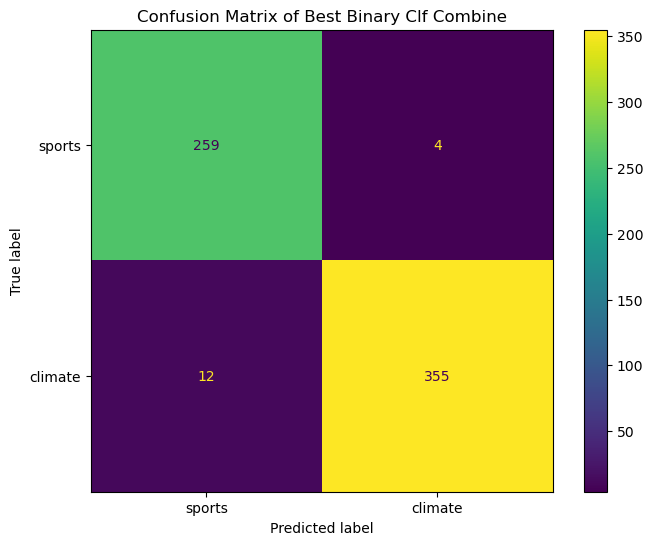

Accuracy score for Best Binary Clf Combine: 0.975
Recall score for Best Binary Clf Combine: 0.967
Precision score for Best Binary Clf Combine: 0.989
F-1 score for Best Binary Clf Combine: 0.978


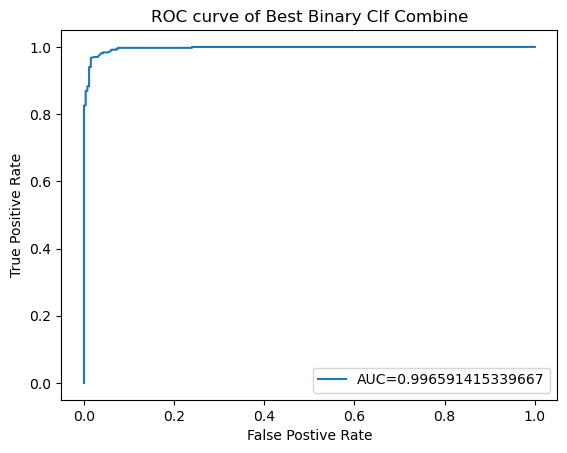

In [86]:
# Best score 0.95999 accuracy with lemmatizing
steps = Pipeline([ ( "vectorizer", CountVectorizer(stop_words='english', min_df = 3)) ,
          ("tf_idf", TfidfTransformer()),
          ('dim_reduction', TruncatedSVD(n_components= 80, random_state= 42 )),
          ("clf", LogisticRegression(C=1000, max_iter=20000, penalty='l1', random_state=42,
                   solver='saga')),
          ])
processed_x  = train_cleaned.apply(lambda x: lemmatize_text2(x))

steps.fit(processed_x, train_y)
test_cleaned = test.full_text.apply(lambda x: clean_without_analysis(x))
test_y = test.root_label.apply(get_root_label)

labels = ['sports', 'climate']
processed_test_x = test_cleaned.apply(lambda x: lemmatize_text2(x))
y_pred_best = steps.predict(processed_test_x)
plot_confusion_matrix(test_y, y_pred_best, labels = labels, name = 'Best Binary Clf Combine', fig_path = 'figs/cm_best.png')
show_metrics(test_y, y_pred_best, name = "Best Binary Clf Combine")
plot_roc(test_y, processed_test_x, steps.predict_proba, name = 'Best Binary Clf Combine', fig_path = "figs/roc_best.png")


## Question 9

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

df = pd.read_csv("./Project1-Classification.csv")

np.random.seed(42)
random.seed(42)

# split the dataset based on multi_class
mtrain, mtest= train_test_split(df[["full_text","leaf_label"]], test_size=0.2)
print('number of training', len(mtrain))
print('number of testing', len(mtest))

# apply the Preprocess
mtrain['cleaned_text'] = mtrain['full_text'].apply(lambda x:preprocess(x))
mtest['cleaned_text'] = mtest['full_text'].apply(lambda x:preprocess(x))


number of training 2520
number of testing 630


In [100]:
# convert labels to integers
def process_multi_labels(text):
    class_to_number = {"chess": 0, "cricket": 1, "hockey":2 , "soccer": 3,
"football": 4, "%22forest%20fire%22": 5, "flood": 6, "earthquake": 7,
"drought": 8}
    if text in class_to_number.keys():
        return class_to_number[text]
    else:
        return -1
def make_preprocess_pipeline(min_df = 3):
    return Pipeline([('count', CountVectorizer(stop_words = 'english', min_df = min_df)), ("tf_idf", TfidfTransformer()) ] )

def plot_confusion_matrix_multi(y, y_pred, labels, name = '', fig_path = None):
    fig, ax = plt.subplots(figsize=(8,6), dpi=100)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=labels)
    ax.set(title = "Confusion Matrix of %s" % (name))
    disp.plot(ax=ax)
    plt.xticks(rotation=90)
    if fig_path is not None:
        plt.savefig(fig_path)
    
    plt.show()
    
    plt.close()

train_multi_y = mtrain.leaf_label.apply(lambda x: process_multi_labels(x))
test_multi_y = mtest.leaf_label.apply(lambda x: process_multi_labels(x))


In [102]:
# convert text to matrix
pipeline = make_preprocess_pipeline(min_df = 3)

train_multi_x = pipeline.fit_transform(mtrain['cleaned_text'])
test_multi_x = pipeline.transform(mtest['cleaned_text'])

train_muti_x = train_multi_x.toarray()
test_multi_x = test_multi_x.toarray()

In [103]:
classes = ["chess", "cricket", "hockey" , "soccer",
"football", "%22forest%20fire%22", "flood", "earthquake",
"drought" ]


# svc_clf_ovo = svm.SVC(kernel='linear', C = 1000, decision_function_shape = 'ovo', random_state= 42)
# svc_clf_ovr = svm.SVC(kernel= 'linear', C= 1000, decision_function_shape= 'ovr', random_state= 42)


Accuracy score for Gaussian Multiple Classes: 0.756
Recall score for Gaussian Multiple Classes: 0.747
Precision score for Gaussian Multiple Classes: 0.730
F-1 score for Gaussian Multiple Classes: 0.728


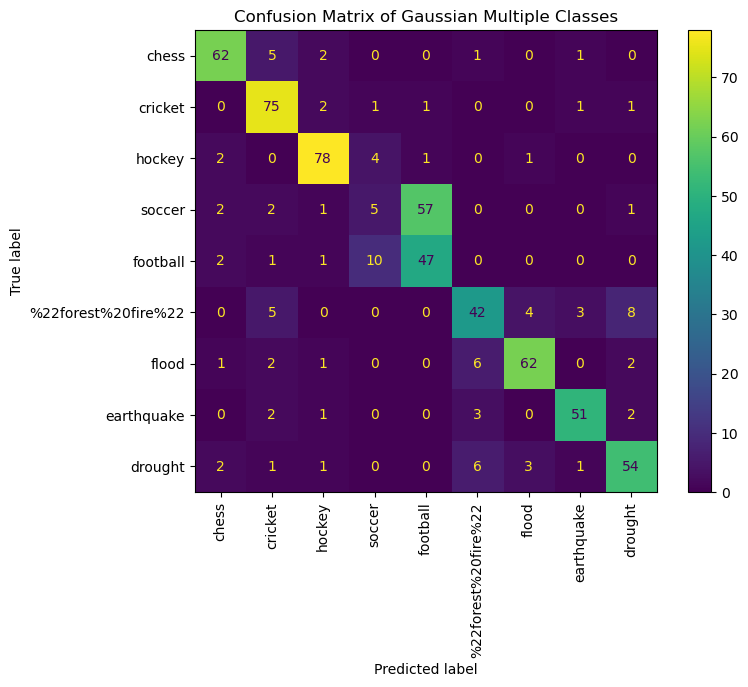

In [104]:
# dimesnion reduction 
nmf = NMF(n_components= 50, init = 'random', random_state= 42, max_iter= 500)
dense_train_multi_x = nmf.fit_transform(train_multi_x)
dense_test_multi_x = nmf.transform(test_multi_x)


# fit data
gnb = GaussianNB()
gnb.fit(dense_train_multi_x, train_multi_y)
# svc_clf_ovo.fit(dense_train_multi_x, train_multi_y)
# svc_clf_ovr.fit(dense_train_multi_x, train_multi_y)

# prediction

y_pred_gnb = gnb.predict(dense_test_multi_x)
show_metrics(test_multi_y, y_pred_gnb,  name = "Gaussian Multiple Classes", average= 'macro')
plot_confusion_matrix_multi(test_multi_y, y_pred_gnb, labels = classes, name = 'Gaussian Multiple Classes', fig_path= 'figs/cm_gnb_multi.png')
# plot_roc(test_multi_y, dense_test_multi_x, gnb.predict_proba, name = "Gaussian Multiple Classes", fig_path= 'figs/roc_gnb_multi.png')

In [109]:
estimator =  OneVsOneClassifier( svm.SVC(kernel= 'linear', random_state= 42) )
# steps = Pipeline(steps = steps)
parameters_ovo = {
    "estimator__C": [10 ** i for i in range(-5, 8)]
}

grid = GridSearchCV(estimator, parameters_ovo, scoring= 'accuracy', cv = 5, n_jobs= -1)
grid.fit(dense_train_multi_x, train_multi_y)
print(grid.best_params_)

{'estimator__C': 10000}


In [110]:
estimator =  OneVsRestClassifier( svm.SVC(kernel= 'linear', random_state= 42) )
# steps = Pipeline(steps = steps)
parameters_ovr = {
    "estimator__C": [10 ** i for i in range(-5, 8)]
}

grid = GridSearchCV(estimator, parameters_ovr, scoring= 'accuracy', cv = 5, n_jobs = -1)
grid.fit(dense_train_multi_x, train_multi_y)
print(grid.best_params_)

{'estimator__C': 10000}


Accuracy score for SVM OVO Multiple Classes: 0.798
Recall score for SVM OVO Multiple Classes: 0.789
Precision score for SVM OVO Multiple Classes: 0.796
F-1 score for SVM OVO Multiple Classes: 0.788


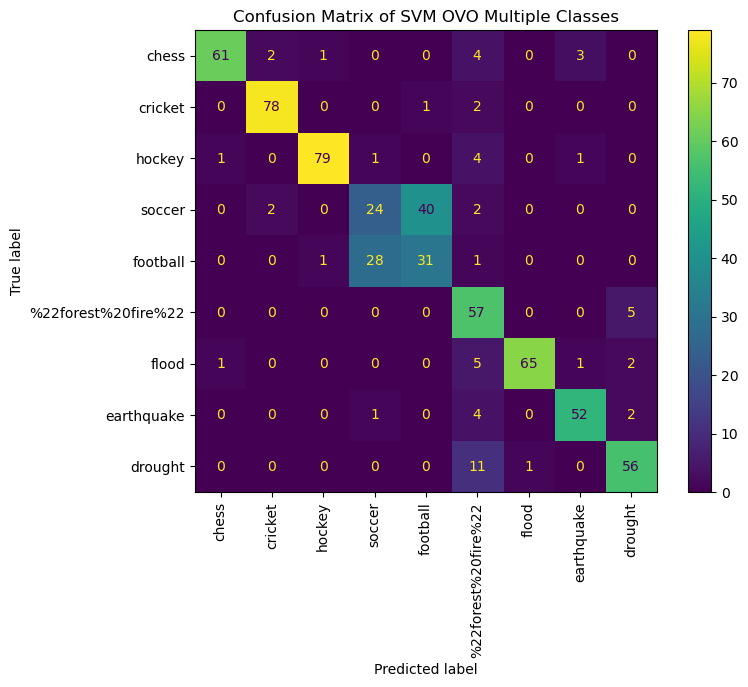

Accuracy score for SVM OVR Multiple Classes: 0.800
Recall score for SVM OVR Multiple Classes: 0.792
Precision score for SVM OVR Multiple Classes: 0.789
F-1 score for SVM OVR Multiple Classes: 0.786


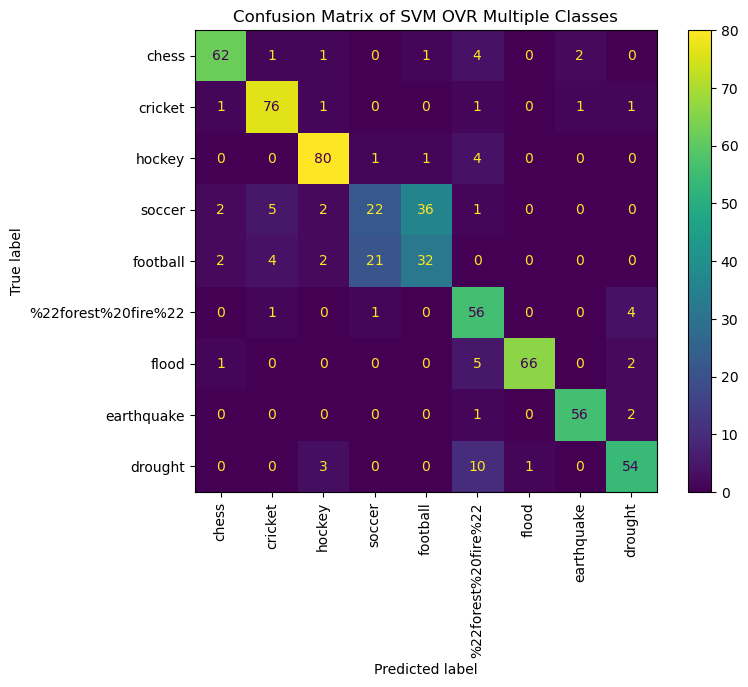

In [111]:
svm_ovo = OneVsOneClassifier( svm.SVC(kernel= 'linear', C = 10000, random_state= 42) )
svm_ovr = OneVsRestClassifier( svm.SVC(kernel= 'linear', C = 10000, random_state= 42) )

svm_ovo.fit(dense_train_multi_x, train_multi_y)
svm_ovr.fit(dense_train_multi_x, train_multi_y)

y_pred_ovo = svm_ovo.predict(dense_test_multi_x)
show_metrics(test_multi_y, y_pred_ovo,  name = "SVM OVO Multiple Classes", average= 'macro')
plot_confusion_matrix_multi(test_multi_y, y_pred_ovo, labels = classes, name = 'SVM OVO Multiple Classes', fig_path= 'figs/cm_svm_ovo_multi.png')

y_pred_ovr = svm_ovr.predict(dense_test_multi_x)
show_metrics(test_multi_y, y_pred_ovr,  name = "SVM OVR Multiple Classes", average= 'macro')
plot_confusion_matrix_multi(test_multi_y, y_pred_ovr, labels = classes, name = 'SVM OVR Multiple Classes', fig_path= 'figs/cm_svm_ovr_multi.png')

In [132]:
# merge football and soccer together and fire and drought all together
def process_multi_labels_merged(text):
    class_to_number = {"chess": 0, "cricket": 1, "hockey":2 , "soccer": 3,
"football": 3, "%22forest%20fire%22": 4, "flood": 5, "earthquake": 6,
"drought": 4}
    if text in class_to_number.keys():
        return class_to_number[text]
    else:
        return -1

train_multi_y_merged = mtrain.leaf_label.apply(lambda x: process_multi_labels_merged(x))
test_multi_y_merged = mtest.leaf_label.apply(lambda x: process_multi_labels_merged(x))

In [133]:
classes_merged = ["chess", "cricket", "hockey" , "soccer_football", "fire_drought", 'flood', 'earthquake' ]

Accuracy score for SVM OVO Merged Subset Classes: 0.9286
Recall score for SVM OVO Merged Subset Classes: 0.9167
Precision score for SVM OVO Merged Subset Classes: 0.9456
F-1 score for SVM OVO Merged Subset Classes: 0.9285


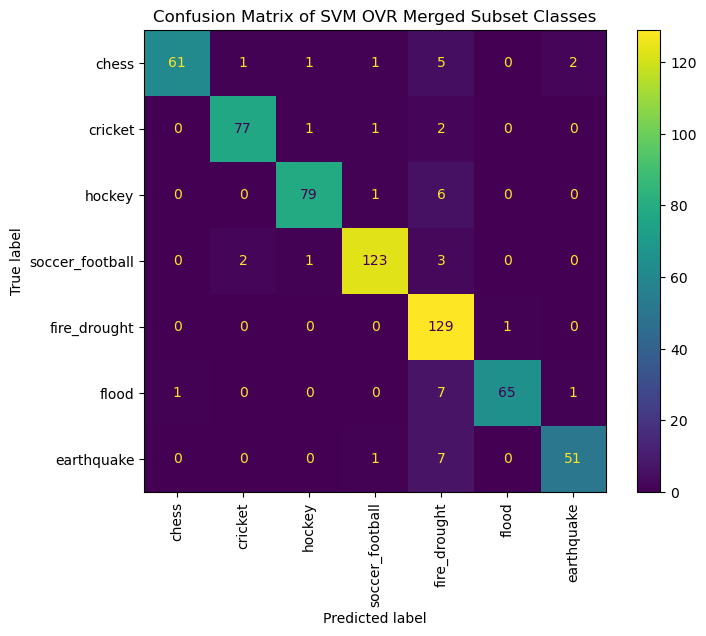

Accuracy score for SVM OVR Merged Subset Classes: 0.9333
Recall score for SVM OVR Merged Subset Classes: 0.9247
Precision score for SVM OVR Merged Subset Classes: 0.9393
F-1 score for SVM OVR Merged Subset Classes: 0.9311


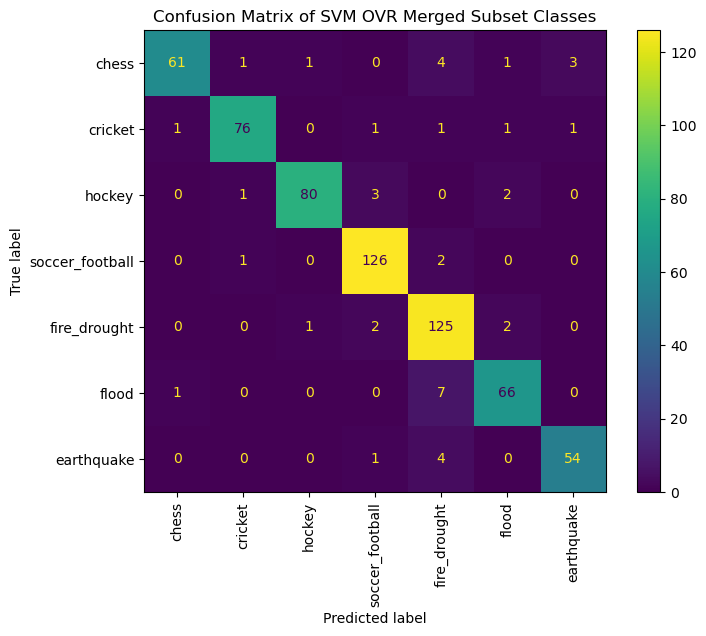

In [137]:
# before down sampling
# gnb = GaussianNB()
svm_ovo = OneVsOneClassifier( svm.SVC(kernel= 'linear', C = 10000, random_state= 42) )
svm_ovr = OneVsRestClassifier( svm.SVC(kernel= 'linear', C = 10000, random_state= 42) )

# gnb.fit(dense_train_multi_x, train_multi_y_merged)
svm_ovo.fit(dense_train_multi_x, train_multi_y_merged)
svm_ovr.fit(dense_train_multi_x, train_multi_y_merged)

# y_pred_gnb = gnb.predict(dense_test_multi_x)
# show_metrics(test_multi_y_merged, y_pred_gnb,  name = "GNB Merged Subset Classes", average= 'macro')
# plot_confusion_matrix_multi(test_multi_y_merged, y_pred_gnb, labels = classes_merged, name = 'GNB Merged Subset Classes', 
#                             fig_path= 'figs/cm_gnb_multi_merged_wo_down_sampling.png')

y_pred_ovo = svm_ovo.predict(dense_test_multi_x)
show_metrics(test_multi_y_merged, y_pred_ovo,  name = "SVM OVO Merged Subset Classes", average= 'macro')
plot_confusion_matrix_multi(test_multi_y_merged, y_pred_ovo, labels = classes_merged, name = 'SVM OVR Merged Subset Classes', 
                            fig_path= 'figs/cm_svm_ovo_multi_merged_wo_down_sampling.png')

y_pred_ovr = svm_ovr.predict(dense_test_multi_x)
show_metrics(test_multi_y_merged, y_pred_ovr,  name = "SVM OVR Merged Subset Classes", average= 'macro')
plot_confusion_matrix_multi(test_multi_y_merged, y_pred_ovr, labels = classes_merged, name = 'SVM OVR Merged Subset Classes',
                            fig_path= 'figs/cm_svm_ovr_multi_merged_wo_down_sampling.png')

Accuracy score for SVM OVO Merged Subset Classes: 0.9349
Recall score for SVM OVO Merged Subset Classes: 0.9285
Precision score for SVM OVO Merged Subset Classes: 0.9406
F-1 score for SVM OVO Merged Subset Classes: 0.9332


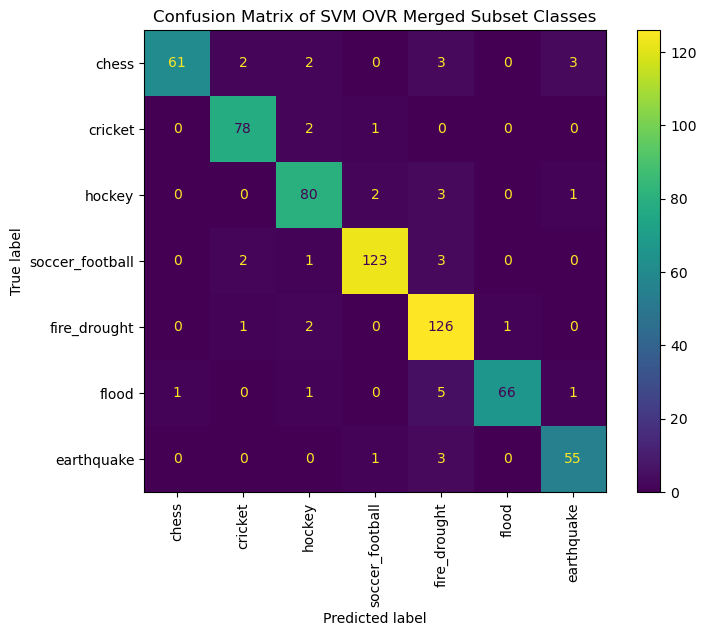

Accuracy score for SVM OVR Merged Subset Classes: 0.9302
Recall score for SVM OVR Merged Subset Classes: 0.9237
Precision score for SVM OVR Merged Subset Classes: 0.9352
F-1 score for SVM OVR Merged Subset Classes: 0.9284


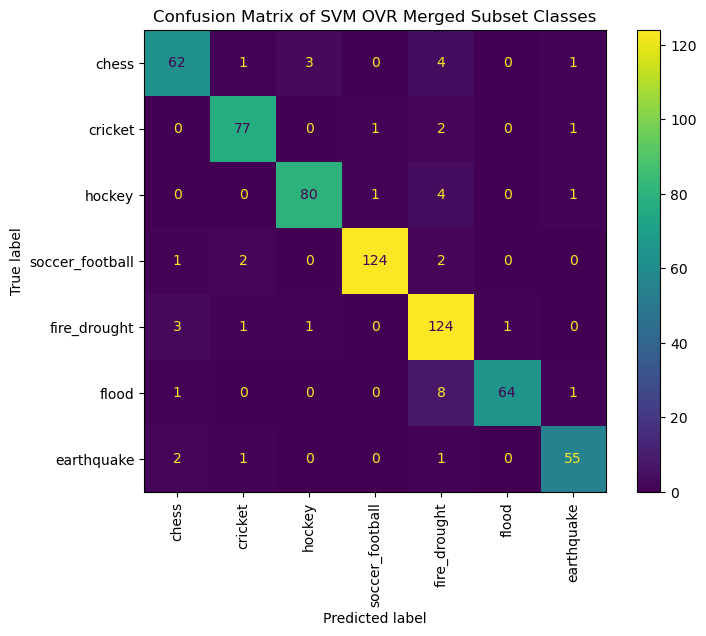

In [143]:

svm_ovo = OneVsOneClassifier( svm.SVC(kernel= 'linear', C = 10000, random_state= 42, class_weight= 'balanced') )
svm_ovr = OneVsRestClassifier( svm.SVC(kernel= 'linear', C = 10000, random_state= 42, class_weight='balanced') )

# gnb.fit(dense_train_multi_x, train_multi_y_merged)
svm_ovo.fit(dense_train_multi_x, train_multi_y_merged)
svm_ovr.fit(dense_train_multi_x, train_multi_y_merged)

# y_pred_gnb = gnb.predict(dense_test_multi_x)
# show_metrics(test_multi_y_merged, y_pred_gnb,  name = "GNB Merged Subset Classes", average= 'macro')
# plot_confusion_matrix_multi(test_multi_y_merged, y_pred_gnb, labels = classes_merged, name = 'GNB Merged Subset Classes', 
#                             fig_path= 'figs/cm_gnb_multi_merged_wo_down_sampling.png')

y_pred_ovo = svm_ovo.predict(dense_test_multi_x)
show_metrics(test_multi_y_merged, y_pred_ovo,  name = "SVM OVO Merged Subset Classes Balanced Mode", average= 'macro')
plot_confusion_matrix_multi(test_multi_y_merged, y_pred_ovo, labels = classes_merged, name = 'SVM OVR Merged Subset Classes Balanced Mode', 
                            fig_path= 'figs/cm_svm_ovo_multi_merged_classes_weighed.png')

y_pred_ovr = svm_ovr.predict(dense_test_multi_x)
show_metrics(test_multi_y_merged, y_pred_ovr,  name = "SVM OVR Merged Subset Classes Balanced Mode", average= 'macro')
plot_confusion_matrix_multi(test_multi_y_merged, y_pred_ovr, labels = classes_merged, name = 'SVM OVR Merged Subset Classes Balanced Mode',
                            fig_path= 'figs/cm_svm_ovr_multi_merged_classes_weighed.png')

In [129]:
# Down sampling
from sklearn.utils import resample
classes = ["chess", "cricket", "hockey" , "soccer",
"football", "%22forest%20fire%22", "flood", "earthquake",
"drought" ]
subset1 = ["%22forest%20fire%22",
"drought"]
down_sampled_train = resample(mtrain.loc[mtrain['leaf_label'].isin(subset1)], n_samples= len(mtrain [mtrain.leaf_label == 'flood']), random_state= 42)
other_train = mtrain.loc[mtrain.leaf_label.isin(set(classes) - set(subset1))]

In [130]:
other_train_x = pipeline.transform(other_train.cleaned_text).toarray()
down_sampled_train_x = pipeline.transform(down_sampled_train.cleaned_text).toarray()
print(other_train_x)
print(down_sampled_train_x.shape)
down_sampled_together_x = np.append(other_train_x, down_sampled_train_x, axis = 0)

other_train_y = other_train.leaf_label.apply(lambda x: process_multi_labels_merged(x))
down_sampled_train_y = down_sampled_train.leaf_label.apply(lambda x: process_multi_labels_merged(x))

down_sampled_together_y = np.append(other_train_y, down_sampled_train_y, axis = 0)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(276, 14077)


Accuracy score for SVM OVO Merged Subset Classes Down Sampling: 0.9254
Recall score for SVM OVO Merged Subset Classes Down Sampling: 0.9218
Precision score for SVM OVO Merged Subset Classes Down Sampling: 0.9239
F-1 score for SVM OVO Merged Subset Classes Down Sampling: 0.9213


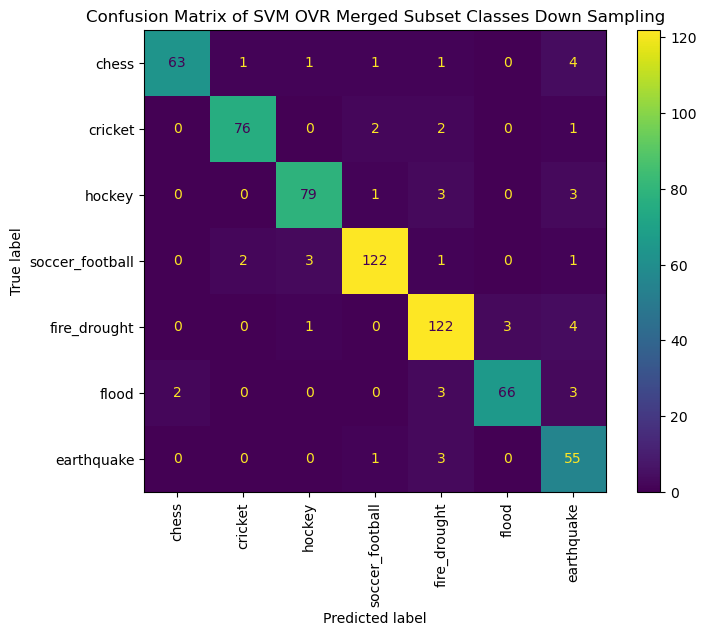

Accuracy score for SVM OVR Merged Subset Classes Down Sampling: 0.9349
Recall score for SVM OVR Merged Subset Classes Down Sampling: 0.9307
Precision score for SVM OVR Merged Subset Classes Down Sampling: 0.9355
F-1 score for SVM OVR Merged Subset Classes Down Sampling: 0.9328


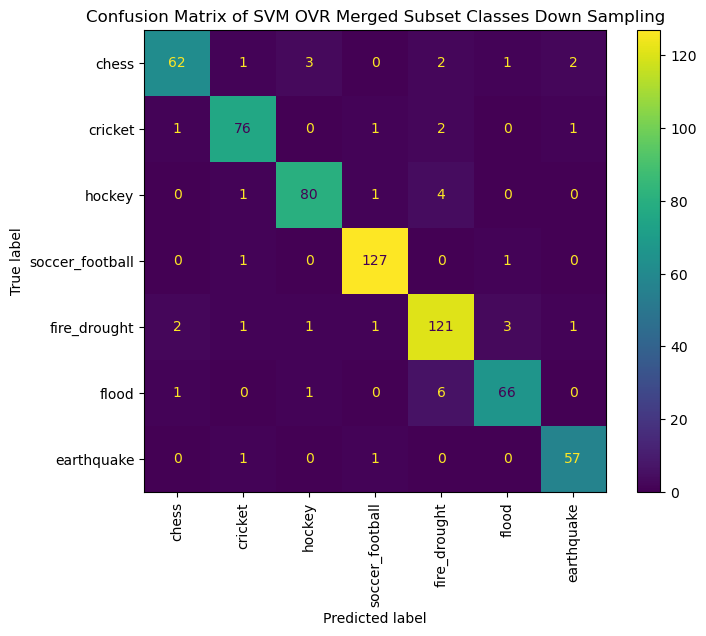

In [144]:
# dim reductionn
nmf = NMF(n_components= 50, init = 'random', random_state= 42, max_iter= 500)
nmf.fit(train_multi_x) 
dense_train_multi_ds_x  = nmf.transform(down_sampled_together_x)
train_multi_y_ds = down_sampled_together_y
# after down sampling

svm_ovo = OneVsOneClassifier( svm.SVC(kernel= 'linear', C = 10000, random_state= 42, ) )
svm_ovr = OneVsRestClassifier( svm.SVC(kernel= 'linear', C = 10000, random_state= 42) )

svm_ovo.fit(dense_train_multi_ds_x, train_multi_y_ds)
svm_ovr.fit(dense_train_multi_ds_x, train_multi_y_ds)

# y_pred_gnb = gnb.predict(dense_test_multi_x)
# show_metrics(test_multi_y_merged, y_pred_gnb,  name = "GNB Merged Subset Classes", average= 'macro')
# plot_confusion_matrix_multi(test_multi_y_merged, y_pred_gnb, labels = classes_merged, name = 'GNB Merged Subset Classes', 
#                             fig_path= 'figs/cm_gnb_multi_merged_down_sampling.png')

y_pred_ovo = svm_ovo.predict(dense_test_multi_x)
show_metrics(test_multi_y_merged, y_pred_ovo,  name = "SVM OVO Merged Subset Classes Down Sampling", average= 'macro')
plot_confusion_matrix_multi(test_multi_y_merged, y_pred_ovo, labels = classes_merged, name = 'SVM OVR Merged Subset Classes Down Sampling', 
                            fig_path= 'figs/cm_svm_ovo_multi_merged_down_sampling.png')

y_pred_ovr = svm_ovr.predict(dense_test_multi_x)
show_metrics(test_multi_y_merged, y_pred_ovr,  name = "SVM OVR Merged Subset Classes Down Sampling", average= 'macro')
plot_confusion_matrix_multi(test_multi_y_merged, y_pred_ovr, labels = classes_merged, name = 'SVM OVR Merged Subset Classes Down Sampling',
                            fig_path= 'figs/cm_svm_ovr_multi_merged_down_sampling.png')


## Question 10

In [145]:
embeddings_dict = {}
dimension_of_glove = 300
with open("glove.6B.300d.txt", 'r') as f: 
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [146]:
# 10(c)
vec1 = embeddings_dict['queen'] - embeddings_dict['king'] - embeddings_dict['wife'] + embeddings_dict['husband']
vec2 = embeddings_dict['queen'] - embeddings_dict['king'] 
vec3 = embeddings_dict['wife'] - embeddings_dict['husband']
value1 = (sum(np.square(vec1)) ) ** 0.5
value2 = (sum(np.square(vec2)) ) ** 0.5
value3 = (sum(np.square(vec3)) ) ** 0.5
print(value1,value2,value3)

6.165036272405068 5.966257954114113 3.1520462339285213


In [155]:
df = pd.read_csv("./Project1-Classification.csv")

np.random.seed(42)
random.seed(42)

# split the dataset based on multi_class
train, test= train_test_split(df[["full_text", "keywords", "summary", "root_label"]], test_size=0.2)
print('number of training', len(train))
print('number of testing', len(test))


number of training 2520
number of testing 630


In [156]:
train ['cleaned_text'] = train.full_text.apply(lambda x: preprocess(x))
test['cleaned_text'] = test.full_text.apply(lambda x: preprocess(x))

In [153]:
# load model first 

glove_filename='glove.6B.300d.txt'
word2vec_output_file = glove_filename+'.word2vec'

glove2word2vec(glove_filename, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)


/tmp/ipykernel_5138/3719968574.py:7: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_filename, word2vec_output_file)


In [154]:
# define transform class 

class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('queen')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

In [157]:
vectorizer = Word2VecVectorizer(model=model)

Loading in word vectors...
Finished loading in word vectors


In [158]:
train_x = vectorizer.transform(train.cleaned_text)
test_x = vectorizer.transform(test.cleaned_text)

Numer of samples with no words found: 0 / 2520
Numer of samples with no words found: 0 / 630


In [177]:
def get_root_label(label):
    if label == 'sports':
        return 1
    if label == "climate":
        return 0
train_y = train.root_label.apply(lambda x:get_root_label(x) )
test_y = test.root_label.apply(lambda x: get_root_label(x))

steps = Pipeline([
    ("clf", None)
])
parameters = {
    "clf":( svm.SVC(kernel='linear', C = 10000, random_state= 42, max_iter= 20000),
                LogisticRegression(penalty= 'l1', random_state= 42, C = 1000, solver= 'saga', max_iter= 20000),
                LogisticRegression(penalty= 'l2', random_state= 42, C = 10000, solver= 'saga', max_iter= 20000),
                GaussianNB())
}


In [178]:
grid_search = GridSearchCV(steps, param_grid=  parameters, n_jobs= - 1, verbose= 5, scoring= 'accuracy')
grid_search.fit(train_x, train_y)
print(grid_search.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END clf=SVC(C=10000, kernel='linear', max_iter=20000, random_state=42);, score=0.931 total time=   0.1s
[CV 1/5] END ..................clf=GaussianNB();, score=0.911 total time=   0.0s
[CV 2/5] END ..................clf=GaussianNB();, score=0.946 total time=   0.0s
[CV 3/5] END ..................clf=GaussianNB();, score=0.933 total time=   0.0s
[CV 5/5] END ..................clf=GaussianNB();, score=0.901 total time=   0.0s
[CV 4/5] END ..................clf=GaussianNB();, score=0.919 total time=   0.0s
[CV 3/5] END clf=SVC(C=10000, kernel='linear', max_iter=20000, random_state=42);, score=0.964 total time=   0.1s
[CV 4/5] END clf=SVC(C=10000, kernel='linear', max_iter=20000, random_state=42);, score=0.927 total time=   0.1s
[CV 2/5] END clf=SVC(C=10000, kernel='linear', max_iter=20000, random_state=42);, score=0.954 total time=   0.1s
[CV 5/5] END clf=SVC(C=10000, kernel='linear', max_iter=20000, random_state=42);, s

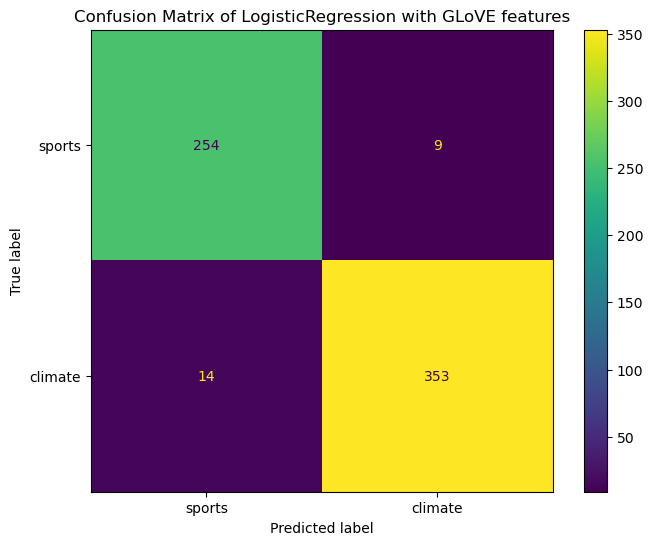

Accuracy score for LogisticRegression with GLoVE features: 0.9635
Recall score for LogisticRegression with GLoVE features: 0.9619
Precision score for LogisticRegression with GLoVE features: 0.9751
F-1 score for LogisticRegression with GLoVE features: 0.9684


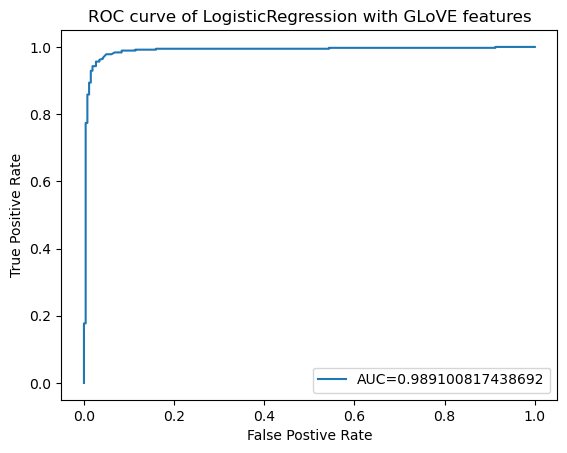

In [171]:
lr_clf = LogisticRegression(C=1000, max_iter=20000, penalty='l1', random_state=42,
                   solver='saga')
pred_lr_y = lr_clf.fit(train_x, train_y).predict(test_x)

plot_confusion_matrix(test_y, pred_lr_y, labels = labels, name = 'LogisticRegression with GLoVE features', fig_path = "figs/cm_lr_glove.png")
show_metrics(test_y, pred_lr_y, name = "LogisticRegression with GLoVE features")
plot_roc(test_y, test_x, lr_clf.decision_function, name = 'LogisticRegression with GLoVE features', fig_path = "figs/roc_lr_glove.png")

In [185]:
dimensions = [50, 100, 200, 300]
accuracies = []
train_y = train.root_label.apply(lambda x:get_root_label(x) )
test_y = test.root_label.apply(lambda x: get_root_label(x))
parent_path = r"glove.6B/"
prefix = "glove.6B."
postfix = "d.txt"
for dim in dimensions:
    glove_file_path = os.path.join(parent_path, prefix + str(dim) + postfix)
    # load model 
    
    word2vec_output_file = "current_model"+'.word2vec'

    glove2word2vec(glove_file_path, word2vec_output_file)
    model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    lr_clf = svm.SVC(kernel='linear', C = 10000, random_state= 42, max_iter= 20000)
    vectorizer = Word2VecVectorizer(model=model)
    train_x = vectorizer.transform(train.cleaned_text)
    test_x = vectorizer.transform(test.cleaned_text)
    
    lr_clf.fit(train_x, train_y)
    pred_y = lr_clf.predict(test_x)
    acc = accuracy_score(test_y, pred_y)
    print("current dimension " + str(dim), acc )
    accuracies.append(acc)

/tmp/ipykernel_5138/2498206860.py:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file_path, word2vec_output_file)


Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 2520
Numer of samples with no words found: 0 / 630


/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/tmp/ipykernel_5138/2498206860.py:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file_path, word2vec_output_file)


current dimension 50 0.8936507936507937
Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 2520
Numer of samples with no words found: 0 / 630


/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/tmp/ipykernel_5138/2498206860.py:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file_path, word2vec_output_file)


current dimension 100 0.8793650793650793
Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 2520
Numer of samples with no words found: 0 / 630


/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/tmp/ipykernel_5138/2498206860.py:14: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file_path, word2vec_output_file)


current dimension 200 0.9507936507936507
Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 2520
Numer of samples with no words found: 0 / 630
current dimension 300 0.9571428571428572


/home/winston/anaconda3/envs/d_mine/lib/python3.8/site-packages/sklearn/svm/_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=20000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


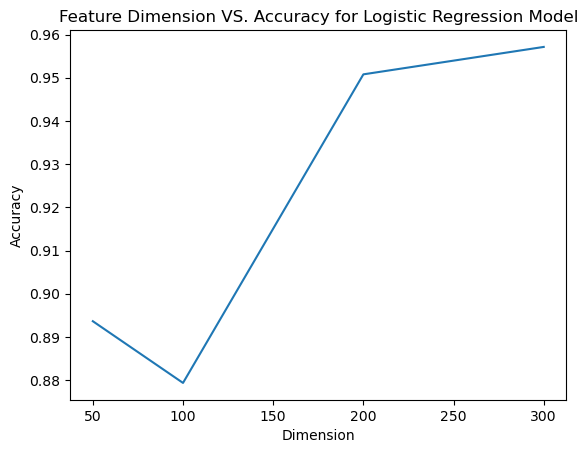

In [186]:

plt.plot(dimensions, accuracies)
plt.title("Feature Dimension VS. Accuracy for Logistic Regression Model")
plt.xlabel("Dimension")
plt.ylabel("Accuracy")
plt.savefig("figs/feature_vs_accuracy.png")
plt.show()

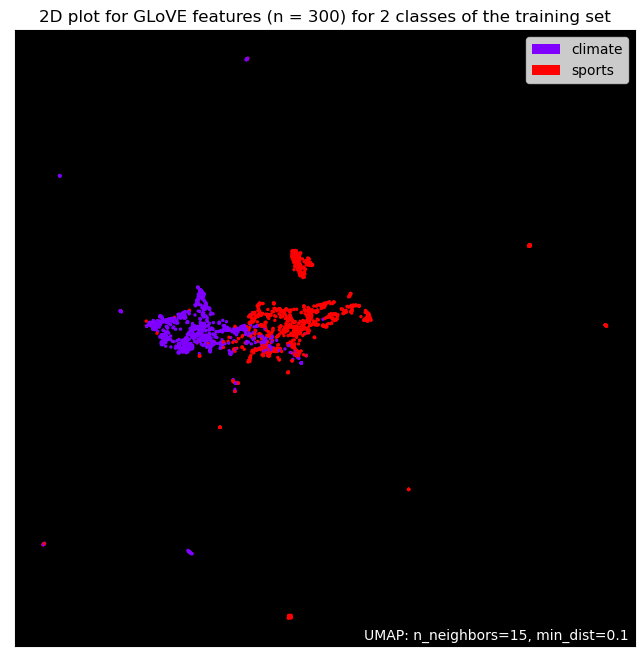

In [197]:
from umap.umap_ import UMAP
import umap.plot

dim_embedding = UMAP(n_components=2, metric='euclidean').fit(train_x)

f = umap.plot.points(dim_embedding, labels=np.array(train.root_label.values), theme='fire')
plt.title('2D plot for GLoVE features (n = ' + str(dim) + ') for 2 classes of the training set')
plt.savefig("figs/2d_glove_features_visual.png")
plt.show()